In [37]:
from __future__ import annotations

from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

In [38]:
root = Path.cwd().resolve()

if root.name == "notebooks":
    root = root.parent

data_direct = root/ "data"
raw_direct = data_direct/ "raw"
interim_direct = data_direct/ "interim"
processed_direct = data_direct/ "processed"

reports_direct = root / "reports"
figures_direct = reports_direct / "figures"
tables_direct = reports_direct / "tables"

for p in [interim_direct, processed_direct, figures_direct, tables_direct]:
    p.mkdir(parents=True, exist_ok=True)

In [39]:
sep = r"\+\+\+\$\+\+\+"

conv_fp = raw_direct / "supreme.conversations.txt"
votes_fp = raw_direct / "supreme.votes.txt"
out_fp = raw_direct / "supreme.outcome.txt"
gender_fp = raw_direct / "supreme.gender.txt"

for fp in [conv_fp, votes_fp, out_fp, gender_fp]:
    if not fp.exists():
        raise FileNotFoundError(f"Missing File: {fp}")

print("All dataset files are present. Let's start.")

All dataset files are present. Let's start.


In [40]:
def read_conversations(fp: Path) -> pd.DataFrame:

    cols = [
        "case_id",
        "utt_id",
        "after_prev",
        "speaker",
        "is_justice",
        "justice_vote",
        "presentation_side",
        "utt",
    ]

    df = pd.read_csv(
        fp,
        sep=sep,
        header=None,
        names=cols,
        engine="python",
        dtype=str,
        on_bad_lines="skip",
    )

    df["utt_id"] = pd.to_numeric(df["utt_id"], errors="coerce")
    df["after_prev"] = df["after_prev"].map({"TRUE": True, "FALSE": False})

    return df


def read_outcome(fp: Path) -> pd.DataFrame:

    df = pd.read_csv(
        fp,
        sep=sep,
        header=None,
        names=["case_id", "winning_side"],
        engine="python",
        dtype=str,
        on_bad_lines="skip",
    )

    return df


def read_gender(fp: Path) -> pd.DataFrame:

    df = pd.read_csv(
        fp,
        sep=sep,
        header=None,
        names=["speaker", "gender"],
        engine="python",
        dtype=str,
        on_bad_lines="skip",
    )

    return df


def read_votes(fp: Path) -> pd.DataFrame:

    rows = []

    with fp.open("r", encoding="utf-8", errors="replace") as f:
        for line in f:
            parts = [p.strip() for p in line.rstrip("\n").split(sep)]
            if not parts or len(parts) < 2:
                continue
            case_id = parts[0]
            for item in parts[1:]:
                if "::" not in item:
                    continue
                j, v = item.split("::", 1)
                rows.append((case_id, j.strip(), v.strip()))

    return pd.DataFrame(rows, columns=["case_id", "justice_name", "vote"])


conv = read_conversations(conv_fp)
out = read_outcome(out_fp)
gen = read_gender(gender_fp)
votes = read_votes(votes_fp)

print("Conversations Shape:", conv.shape)
print("Outcome Shape:", out.shape)
print("Gender Shape:", gen.shape)
print("Votes Shape:", votes.shape)

Conversations Shape: (51498, 8)
Outcome Shape: (196, 2)
Gender Shape: (326, 2)
Votes Shape: (0, 3)


In [41]:
conv.head(3)
out.head(3)
votes.head(5)
gen.head(5)

print("Unique Cases in Conversations:", conv["case_id"].nunique())
print("Unique Speakers:", conv["speaker"].nunique())

print("Utterances:", len(conv))
print("Justice Utterances:", int((conv["is_justice"] == "JUSTICE").sum()))
print("Non-Justice Utterances:", int((conv["is_justice"] != "JUSTICE").sum()))

print("Winning Counts:")
print(out["winning_side"].value_counts(dropna=False))

print("Missing Values in Conversations:")
print(conv.isna().sum().sort_values(ascending=False).head(12))


Unique Cases in Conversations: 204
Unique Speakers: 326
Utterances: 51498
Justice Utterances: 0
Non-Justice Utterances: 51498
Winning Counts:
winning_side
PETITIONER    134
RESPONDENT     62
Name: count, dtype: int64
Missing Values in Conversations:
after_prev           51498
case_id                  0
utt_id                   0
speaker                  0
is_justice               0
justice_vote             0
presentation_side        0
utt                      0
dtype: int64


In [42]:
case_len = (
    conv.groupby("case_id", as_index=False)
    .agg(utt_n=("utt_id", "count"), speaker_n=("speaker", "nunique"))
    .sort_values("utt_n", ascending=False)
)

case_len.head(10)


,case_id,utt_n,speaker_n
88,04-373,585,11
123,04-9728,502,11
6,03-1164,463,10
113,04-721,440,10
150,05-204,421,12
116,04-848,408,10
120,04-905,399,10
54,04-1152,397,10
106,04-631,393,11
162,05-547,393,11


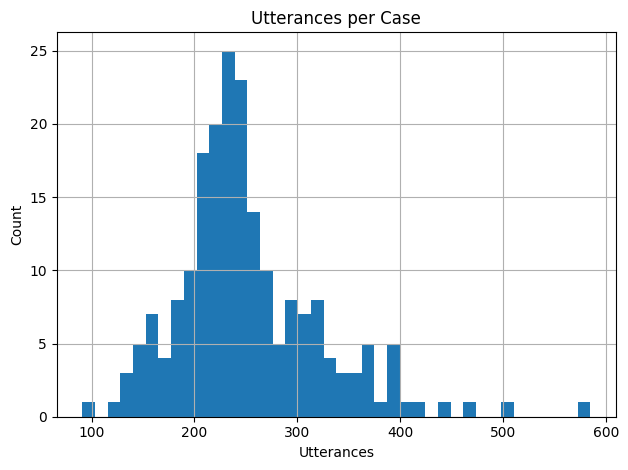

In [43]:
plt.figure()

case_len["utt_n"].hist(bins=40)
plt.title("Utterances per Case")
plt.xlabel("Utterances")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

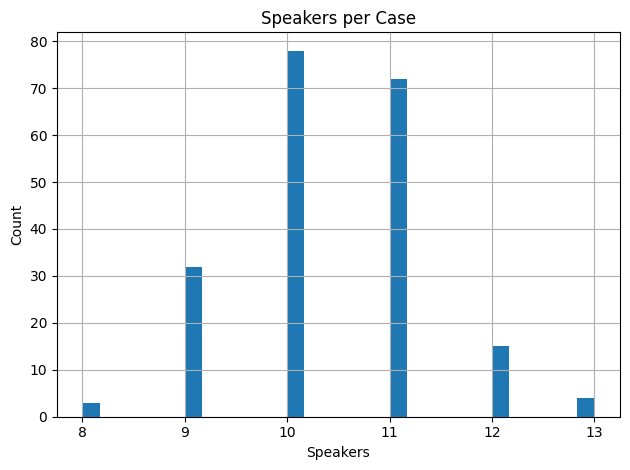

In [44]:
plt.figure()

case_len["speaker_n"].hist(bins=30)
plt.title("Speakers per Case")
plt.xlabel("Speakers")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [45]:
side_counts = conv["presentation_side"].fillna("EMPTY").value_counts()
side_counts

presentation_side
PETITIONER     25697
RESPONDENT     25147
None             446
                 208
Name: count, dtype: int64

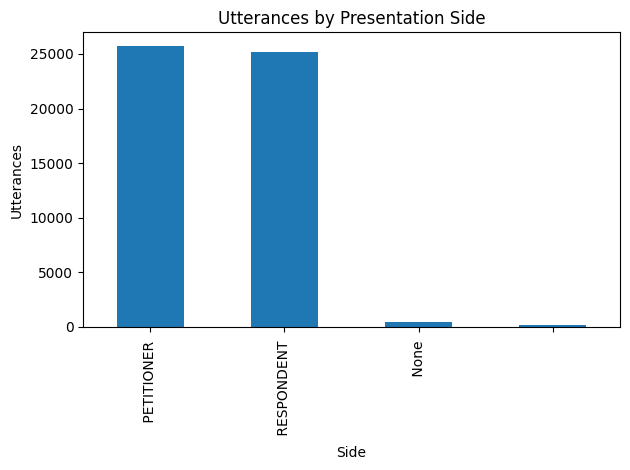

In [46]:
plt.figure()

side_counts.plot(kind="bar")
plt.title("Utterances by Presentation Side")
plt.xlabel("Side")
plt.ylabel("Utterances")
plt.show()

In [47]:
gender_counts = gen["gender"].value_counts(dropna=False)
gender_counts

gender
male      266
female     57
NA          3
Name: count, dtype: int64

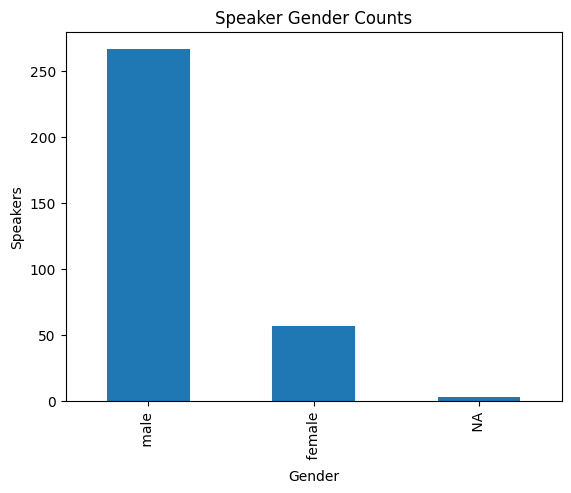

In [48]:
plt.figure()

gender_counts.plot(kind="bar")
plt.title("Speaker Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Speakers")
plt.show()

In [49]:
conv2 = conv.merge(out, on="case_id", how="left")

print("Cases Missing Outcome:", int(conv2["winning_side"].isna().any()))
print("Outcome Coverage/Unique Cases:")
print(conv2.drop_duplicates("case_id")["winning_side"].isna().value_counts())

Cases Missing Outcome: 1
Outcome Coverage/Unique Cases:
winning_side
False    196
True       8
Name: count, dtype: int64


In [50]:
meta_fp = tables_direct / "eda_case_stats.csv"
case_len.to_csv(meta_fp, index=False)
print("Saved:", meta_fp)

Saved: /Users/Sumaitat/Coding Projects/ML_SupremeCourtOutcomePrediction/reports/tables/eda_case_stats.csv
